<a href="https://colab.research.google.com/github/chemvatho/isthmian-script/blob/main/Swadesh_list_Language_Family_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!/usr/bin/env python3
"""
Isthmus Script Languages Dataset Parser
========================================
Parses comparative wordlist data for Mesoamerican languages
relevant to the Cologne Isthmus Script decipherment project.

Language families represented:
- Otomanguean: Otomian, Trique, Mixtec, Zapotec, Mazahua
- Mixe-Zoquean: Popoluca
- Totonacan: Totonac
- Isolate: Huave
- Chontal (Tequistlatecan)
"""

import pandas as pd
import re
import json
from collections import defaultdict, Counter
import unicodedata

# Read the CSV with proper handling of multi-line cells
df = pd.read_csv('Isthmus_script_languages.csv', encoding='utf-8')

print("=" * 80)
print("ISTHMUS SCRIPT LANGUAGES DATASET - PARSING REPORT")
print("=" * 80)

# Display column structure
print("\n1. COLUMN STRUCTURE")
print("-" * 40)
for i, col in enumerate(df.columns):
    print(f"  [{i}] {col}")

# Get the dialect/variety info from row 0
print("\n2. LANGUAGE VARIETIES (from header row)")
print("-" * 40)
varieties = df.iloc[0].to_dict()
for col, variety in varieties.items():
    if pd.notna(variety) and variety.strip():
        print(f"  {col}: {variety}")

# Remove the variety row and reset
df_clean = df.iloc[1:].copy()
df_clean.columns = df.columns
df_clean = df_clean.reset_index(drop=True)

# Rename columns for clarity
column_mapping = {
    '№': 'entry_num',
    'English': 'gloss',
    'Otomian languages': 'otomian',
    'Trique languages': 'trique',
    'Mixtec languages': 'proto_mixtec',
    'Unnamed: 4': 'mixtec_tlaxiaco',
    'Zapotec languages': 'zapotec_isthmus',
    'Unnamed: 6': 'zapotec_xhon',
    'Mazahua languages': 'mazahua',
    'Totonac languages': 'totonac',
    'Popoluca languages': 'popoluca',
    'Huave languages': 'huave',
    'Chontal languages': 'chontal'
}

# Apply mapping where columns exist
new_columns = []
for col in df_clean.columns:
    if col in column_mapping:
        new_columns.append(column_mapping[col])
    else:
        new_columns.append(col)
df_clean.columns = new_columns

print("\n3. DATASET STATISTICS")
print("-" * 40)
print(f"  Total entries (glosses): {len(df_clean)}")
print(f"  Languages/varieties: {len(df_clean.columns) - 2}")  # minus entry_num and gloss

# Count non-empty cells per language
print("\n4. DATA COMPLETENESS BY LANGUAGE")
print("-" * 40)
language_cols = [c for c in df_clean.columns if c not in ['entry_num', 'gloss']]

completeness = {}
for col in language_cols:
    non_empty = df_clean[col].notna().sum()
    non_empty_actual = df_clean[col].apply(lambda x: bool(str(x).strip()) if pd.notna(x) else False).sum()
    completeness[col] = non_empty_actual
    pct = (non_empty_actual / len(df_clean)) * 100
    print(f"  {col:20s}: {non_empty_actual:3d} entries ({pct:5.1f}%)")

# Language family groupings
print("\n5. LANGUAGE FAMILY GROUPINGS")
print("-" * 40)
families = {
    'Otomanguean': {
        'Oto-Pamean': ['otomian', 'mazahua'],
        'Mixtecan': ['trique', 'proto_mixtec', 'mixtec_tlaxiaco'],
        'Zapotecan': ['zapotec_isthmus', 'zapotec_xhon']
    },
    'Mixe-Zoquean': ['popoluca'],
    'Totonacan': ['totonac'],
    'Huavean (isolate)': ['huave'],
    'Tequistlatecan': ['chontal']
}

for family, members in families.items():
    print(f"\n  {family}:")
    if isinstance(members, dict):
        for branch, langs in members.items():
            print(f"    └─ {branch}: {', '.join(langs)}")
    else:
        print(f"    └─ {', '.join(members)}")

# Extract and analyze Proto-Mixtec forms
print("\n6. PROTO-MIXTEC RECONSTRUCTIONS")
print("-" * 40)
proto_mixtec_forms = df_clean[['gloss', 'proto_mixtec']].dropna(subset=['proto_mixtec'])
proto_mixtec_forms = proto_mixtec_forms[proto_mixtec_forms['proto_mixtec'].str.strip() != '']

print(f"  Total Proto-Mixtec forms: {len(proto_mixtec_forms)}")
print("\n  Sample Proto-Mixtec reconstructions:")
for _, row in proto_mixtec_forms.head(15).iterrows():
    gloss = str(row['gloss']).replace('\n', ' ')[:25]
    form = str(row['proto_mixtec'])
    print(f"    '{gloss:25s}' : {form}")

# Phoneme inventory extraction
print("\n7. PHONEME/GRAPHEME INVENTORY ANALYSIS")
print("-" * 40)

def extract_segments(text):
    """Extract potential phonemic segments from transcriptions"""
    if pd.isna(text) or not str(text).strip():
        return set()

    text = str(text)
    # Remove common annotations
    text = re.sub(r'\([^)]*\)', '', text)  # Remove parenthetical notes
    text = re.sub(r'\*', '', text)  # Remove reconstruction markers
    text = re.sub(r'[0-9]+', '', text)  # Remove tone numbers for now
    text = re.sub(r'[,;/\-\s]+', ' ', text)  # Normalize separators

    # Get unique characters (simplified)
    chars = set()
    for char in text:
        if unicodedata.category(char)[0] == 'L':  # Letters only
            chars.add(char.lower())
    return chars

# Collect segments per language
language_inventories = {}
for col in language_cols:
    all_segments = set()
    for val in df_clean[col]:
        all_segments.update(extract_segments(val))
    language_inventories[col] = sorted(all_segments)

print("\n  Unique graphemes per language:")
for lang, segments in language_inventories.items():
    print(f"    {lang:20s}: {len(segments):3d} unique characters")

# Semantic domain analysis
print("\n8. SEMANTIC DOMAIN CATEGORIZATION")
print("-" * 40)

# Define semantic domains based on Swadesh list categories
semantic_domains = {
    'pronouns': ['I', 'you', 'he', 'we', 'they', 'this', 'that'],
    'interrogatives': ['who', 'what', 'where', 'when', 'how'],
    'body_parts': ['head', 'eye', 'ear', 'nose', 'mouth', 'tooth', 'tongue',
                   'hand', 'foot', 'heart', 'blood', 'bone', 'skin', 'hair',
                   'belly', 'neck', 'knee', 'finger', 'leg', 'breast', 'liver',
                   'back', 'fingernail', 'wing', 'tail', 'feather', 'horn'],
    'kinship': ['mother', 'father', 'wife', 'husband', 'child', 'man', 'woman'],
    'animals': ['dog', 'fish', 'bird', 'snake', 'louse', 'worm', 'animal',
                'deer', 'mouse', 'rabbit', 'eagle', 'spider'],
    'nature': ['sun', 'moon', 'star', 'water', 'rain', 'river', 'lake', 'sea',
               'fire', 'stone', 'sand', 'earth', 'cloud', 'sky', 'wind',
               'mountain', 'tree', 'forest', 'leaf', 'root', 'flower', 'grass'],
    'colors': ['red', 'green', 'yellow', 'white', 'black'],
    'numerals': ['one', 'two', 'three', 'four', 'five', 'six', 'seven',
                 'eight', 'nine', 'ten'],
    'verbs': ['eat', 'drink', 'sleep', 'die', 'kill', 'walk', 'come', 'go',
              'see', 'hear', 'know', 'give', 'say', 'burn', 'fly', 'swim',
              'sit', 'stand', 'lie', 'bite', 'suck', 'spit'],
    'adjectives': ['big', 'small', 'long', 'short', 'good', 'bad', 'new',
                   'old', 'hot', 'cold', 'wet', 'dry', 'full', 'round']
}

# Categorize entries
domain_coverage = defaultdict(lambda: defaultdict(int))

for _, row in df_clean.iterrows():
    gloss = str(row['gloss']).lower().replace('\n', ' ')

    for domain, keywords in semantic_domains.items():
        for keyword in keywords:
            if keyword.lower() in gloss:
                for lang in language_cols:
                    if pd.notna(row[lang]) and str(row[lang]).strip():
                        domain_coverage[domain][lang] += 1
                break

print("\n  Entries per semantic domain:")
for domain in semantic_domains.keys():
    total = sum(domain_coverage[domain].values())
    if total > 0:
        print(f"    {domain:15s}: {total // len(language_cols):3d} avg entries")

# Detect Spanish loanwords
print("\n9. SPANISH LOANWORD DETECTION")
print("-" * 40)

spanish_markers = ['Spanish', 'spanish', '(Spanish)']
loanwords = defaultdict(list)

for _, row in df_clean.iterrows():
    gloss = str(row['gloss']).replace('\n', ' ')
    for lang in language_cols:
        val = str(row[lang]) if pd.notna(row[lang]) else ''
        for marker in spanish_markers:
            if marker in val:
                loanwords[lang].append(gloss)
                break

print("\n  Spanish loans marked per language:")
for lang, loans in sorted(loanwords.items(), key=lambda x: -len(x[1])):
    if loans:
        print(f"    {lang:20s}: {len(loans):2d} marked loans")
        for loan in loans[:3]:
            print(f"      - {loan[:40]}")

# Create structured output
print("\n10. GENERATING STRUCTURED DATA FILES")
print("-" * 40)

# Create a clean JSON export
output_data = {
    'metadata': {
        'title': 'Isthmus Script Languages Comparative Wordlist',
        'total_entries': int(len(df_clean)),
        'languages': language_cols,
        'families': families
    },
    'completeness': {k: int(v) for k, v in completeness.items()},
    'entries': []
}

for _, row in df_clean.iterrows():
    entry = {
        'id': row['entry_num'],
        'gloss': str(row['gloss']).replace('\n', ' ') if pd.notna(row['gloss']) else '',
        'forms': {}
    }
    for lang in language_cols:
        if pd.notna(row[lang]) and str(row[lang]).strip():
            entry['forms'][lang] = str(row[lang])
    output_data['entries'].append(entry)

# Save JSON
with open('isthmus_parsed.json', 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)
print("  ✓ Saved: isthmus_parsed.json")

# Save clean CSV
df_clean.to_csv('isthmus_cleaned.csv', index=False, encoding='utf-8')
print("  ✓ Saved: isthmus_cleaned.csv")

# Create a Proto-Mixtec focused file
mixtec_cols = ['entry_num', 'gloss', 'proto_mixtec', 'trique']
# Add the Tlaxiaco column if it exists
if 'Unnamed: 5' in df_clean.columns:
    mixtec_cols.append('Unnamed: 5')
proto_mixtec_data = df_clean[mixtec_cols].copy()
proto_mixtec_data = proto_mixtec_data.dropna(subset=['proto_mixtec'])
proto_mixtec_data.to_csv('proto_mixtec_forms.csv', index=False, encoding='utf-8')
print("  ✓ Saved: proto_mixtec_forms.csv")

# Summary statistics table
print("\n" + "=" * 80)
print("PARSING COMPLETE - SUMMARY")
print("=" * 80)
print(f"""
  Dataset: Isthmus Script Languages Comparative Wordlist

  Entries:     {len(df_clean)} glosses (Swadesh-style list)
  Languages:   {len(language_cols)} varieties across 5 families

  Best documented:
    - Zapotec (Isthmus): {completeness.get('zapotec_isthmus', 0)} entries
    - Otomian:          {completeness.get('otomian', 0)} entries
    - Chontal:          {completeness.get('chontal', 0)} entries

  Proto-forms available:
    - Proto-Mixtec:     {len(proto_mixtec_forms)} reconstructions

  Relevance to Cologne Project:
    ✓ Otomanguean data (for Proto-Otomanguean reconstruction)
    ✓ Popoluca data (for Proto-Mixe-Zoquean comparison)
    ✓ Multiple Zapotecan varieties (Isthmus region focus)

  Output files:
    - isthmus_parsed.json   (structured data)
    - isthmus_cleaned.csv   (cleaned tabular data)
    - proto_mixtec_forms.csv (Proto-Mixtec focus)
""")

ISTHMUS SCRIPT LANGUAGES DATASET - PARSING REPORT

1. COLUMN STRUCTURE
----------------------------------------
  [0] №
  [1] English
  [2] Otomian languages
  [3] Trique languages
  [4] Mixtec languages
  [5] Unnamed: 5
  [6] Zapotec languages
  [7] Unnamed: 7
  [8] Mazahua languages
  [9] Totonac languages
  [10] Popoluca languages
  [11] Huave languages
  [12] Chontal languages

2. LANGUAGE VARIETIES (from header row)
----------------------------------------
  Otomian languages: (various)
  Trique languages: San Juan Copala
  Mixtec languages: Proto-Mixtec
  Unnamed: 5: Tlaxiaco/Putla area Mixtec; unknown dialect
  Zapotec languages: Isthmus
  Unnamed: 7: Xhon
  Mazahua languages: Michoacan, Central
  Totonac languages: (various)
  Popoluca languages: (various)
  Huave languages: (various)
  Chontal languages: (various)

3. DATASET STATISTICS
----------------------------------------
  Total entries (glosses): 240
  Languages/varieties: 11

4. DATA COMPLETENESS BY LANGUAGE
----------

In [6]:
#!/usr/bin/env python3
"""
Advanced Linguistic Analysis: Sound Correspondences & Cognate Detection
========================================================================
For the Cologne Isthmus Script Project application
"""

import pandas as pd
import re
import json
from collections import defaultdict, Counter
from itertools import combinations
import unicodedata

# Load the parsed data
with open('isthmus_parsed.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print("=" * 80)
print("ADVANCED LINGUISTIC ANALYSIS")
print("Sound Correspondences & Potential Cognate Detection")
print("=" * 80)

# ============================================================================
# 1. DETAILED PHONEME INVENTORY EXTRACTION
# ============================================================================
print("\n" + "=" * 80)
print("1. PHONEME INVENTORY BY LANGUAGE")
print("=" * 80)

def normalize_form(text):
    """Normalize a linguistic form for comparison"""
    if not text:
        return ''
    # Remove parenthetical notes
    text = re.sub(r'\([^)]*\)', '', text)
    # Remove reconstruction asterisks
    text = re.sub(r'\*', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_phonemes(text):
    """Extract phonemic segments with diacritics preserved"""
    if not text:
        return []

    text = normalize_form(text)
    segments = []

    # Common digraphs/trigraphs in Mesoamerican orthographies
    digraphs = ['ts', 'tz', 'ch', 'dz', 'gu', 'qu', 'hu', 'ng', 'ñh', 'xh',
                'nd', 'mb', 'nh', 'th', 'ph', 'kh', 'tx', 'dj', 'nz', 'ny']

    i = 0
    while i < len(text):
        # Skip non-letter characters but note tone markers
        if not text[i].isalpha() and text[i] not in "'ʔʼˀ":
            i += 1
            continue

        # Check for digraphs first
        found_digraph = False
        for dg in digraphs:
            if text[i:i+len(dg)].lower() == dg:
                # Include any following diacritics
                end = i + len(dg)
                while end < len(text) and unicodedata.category(text[end]).startswith('M'):
                    end += 1
                segments.append(text[i:end].lower())
                i = end
                found_digraph = True
                break

        if not found_digraph:
            # Single character with potential combining diacritics
            char = text[i]
            end = i + 1
            while end < len(text) and unicodedata.category(text[end]).startswith('M'):
                end += 1
            segments.append(text[i:end].lower())
            i = end

    return segments

# Build phoneme inventories
phoneme_inventories = defaultdict(Counter)

for entry in data['entries']:
    for lang, form in entry['forms'].items():
        if form:
            # Handle multiple forms separated by comma
            for variant in form.split(','):
                segments = extract_phonemes(variant)
                for seg in segments:
                    phoneme_inventories[lang][seg] += 1

# Display inventories
print("\nConsonant and vowel inventories (frequency > 5):\n")

for lang in sorted(phoneme_inventories.keys()):
    inventory = phoneme_inventories[lang]
    common_segments = [seg for seg, count in inventory.most_common(50) if count >= 5]

    # Rough categorization
    vowels = [s for s in common_segments if s[0] in 'aeiouɨɛɔəʌæœøüöä']
    consonants = [s for s in common_segments if s not in vowels]

    print(f"\n{lang.upper()}")
    print(f"  Vowels ({len(vowels)}):     {' '.join(sorted(vowels))}")
    print(f"  Consonants ({len(consonants)}): {' '.join(sorted(consonants)[:25])}")

# ============================================================================
# 2. SOUND CORRESPONDENCE DETECTION (Otomanguean focus)
# ============================================================================
print("\n" + "=" * 80)
print("2. SOUND CORRESPONDENCES WITHIN OTOMANGUEAN")
print("=" * 80)

# Focus on Otomanguean languages for internal comparison
otomanguean_langs = ['otomian', 'trique', 'proto_mixtec', 'Unnamed: 5',
                      'zapotec_isthmus', 'Unnamed: 7', 'mazahua']

# Build correspondence pairs
correspondence_pairs = defaultdict(Counter)

for entry in data['entries']:
    forms = entry['forms']
    gloss = entry['gloss']

    # Get initial segments for each language
    initial_segments = {}
    for lang in otomanguean_langs:
        if lang in forms and forms[lang]:
            segs = extract_phonemes(forms[lang].split(',')[0])
            if segs:
                initial_segments[lang] = segs[0]

    # Compare pairs
    for lang1, lang2 in combinations(otomanguean_langs, 2):
        if lang1 in initial_segments and lang2 in initial_segments:
            seg1 = initial_segments[lang1]
            seg2 = initial_segments[lang2]
            correspondence_pairs[(lang1, lang2)][(seg1, seg2)] += 1

print("\nInitial consonant correspondences (top patterns):\n")

# Focus on key pairs
key_pairs = [
    ('otomian', 'zapotec_isthmus'),
    ('proto_mixtec', 'zapotec_isthmus'),
    ('trique', 'Unnamed: 5'),
    ('otomian', 'mazahua'),
]

for pair in key_pairs:
    if pair in correspondence_pairs:
        corr = correspondence_pairs[pair]
        print(f"\n{pair[0]} ↔ {pair[1]}:")
        top_corr = corr.most_common(8)
        for (seg1, seg2), count in top_corr:
            if count >= 2:
                print(f"    {seg1:6s} : {seg2:6s}  ({count} instances)")

# ============================================================================
# 3. POTENTIAL COGNATE SETS
# ============================================================================
print("\n" + "=" * 80)
print("3. POTENTIAL COGNATE SETS (Cross-family)")
print("=" * 80)

def phonetic_similarity(form1, form2):
    """Calculate rough phonetic similarity between two forms"""
    if not form1 or not form2:
        return 0

    seg1 = set(extract_phonemes(form1))
    seg2 = set(extract_phonemes(form2))

    if not seg1 or not seg2:
        return 0

    intersection = len(seg1 & seg2)
    union = len(seg1 | seg2)

    return intersection / union if union > 0 else 0

# Look for potential cognates between families
print("\nHigh-similarity forms between language families:\n")

mixe_zoque = ['popoluca']
totonacan = ['totonac']
huavean = ['huave']
chontal_fam = ['chontal']

family_pairs = [
    ('Otomanguean', otomanguean_langs, 'Mixe-Zoquean', mixe_zoque),
    ('Otomanguean', otomanguean_langs, 'Totonacan', totonacan),
    ('Mixe-Zoquean', mixe_zoque, 'Totonacan', totonacan),
]

potential_cognates = []

for entry in data['entries']:
    forms = entry['forms']
    gloss = entry['gloss']

    # Check Popoluca vs Otomanguean (potential loans or cognates)
    if 'popoluca' in forms:
        pop_form = forms['popoluca']
        for oto_lang in ['zapotec_isthmus', 'otomian', 'proto_mixtec']:
            if oto_lang in forms:
                oto_form = forms[oto_lang]
                sim = phonetic_similarity(pop_form, oto_form)
                if sim > 0.4:
                    potential_cognates.append({
                        'gloss': gloss,
                        'popoluca': pop_form,
                        oto_lang: oto_form,
                        'similarity': sim
                    })

# Display potential cognates/loans
print("Popoluca ↔ Otomanguean (possible loans/cognates):\n")
seen_glosses = set()
for item in sorted(potential_cognates, key=lambda x: -x['similarity'])[:15]:
    if item['gloss'] not in seen_glosses:
        print(f"  '{item['gloss']}'")
        print(f"    Popoluca: {item.get('popoluca', 'N/A')}")
        for lang in ['zapotec_isthmus', 'otomian', 'proto_mixtec']:
            if lang in item:
                print(f"    {lang}: {item[lang]}")
        print(f"    Similarity: {item['similarity']:.2f}")
        print()
        seen_glosses.add(item['gloss'])

# ============================================================================
# 4. PROTO-MIXTEC FORM ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("4. PROTO-MIXTEC RECONSTRUCTION ANALYSIS")
print("=" * 80)

proto_mixtec_entries = []
for entry in data['entries']:
    if 'proto_mixtec' in entry['forms']:
        proto_mixtec_entries.append({
            'gloss': entry['gloss'],
            'proto_form': entry['forms']['proto_mixtec'],
            'trique': entry['forms'].get('trique', ''),
            'mixtec_daughter': entry['forms'].get('Unnamed: 5', '')
        })

print(f"\nTotal Proto-Mixtec reconstructions: {len(proto_mixtec_entries)}")

# Analyze proto-Mixtec phoneme patterns
proto_phonemes = Counter()
for entry in proto_mixtec_entries:
    segs = extract_phonemes(entry['proto_form'])
    for seg in segs:
        proto_phonemes[seg] += 1

print("\nProto-Mixtec phoneme frequency:")
print("-" * 40)
for phoneme, count in proto_phonemes.most_common(25):
    bar = '█' * (count // 2)
    print(f"  {phoneme:6s} : {count:3d} {bar}")

# Identify systematic sound changes Proto-Mixtec → daughter languages
print("\nSound changes: Proto-Mixtec → Tlaxiaco/Putla Mixtec")
print("-" * 50)

pm_to_daughter = defaultdict(Counter)
for entry in proto_mixtec_entries:
    pm_segs = extract_phonemes(entry['proto_form'])
    da_segs = extract_phonemes(entry['mixtec_daughter'])

    # Align by position (simplified)
    for i, pm_seg in enumerate(pm_segs[:min(3, len(pm_segs))]):
        if i < len(da_segs):
            pm_to_daughter[pm_seg][da_segs[i]] += 1

print("\nInitial position correspondences:")
for pm_seg in sorted(pm_to_daughter.keys()):
    correspondences = pm_to_daughter[pm_seg]
    if correspondences.total() >= 3:
        top_corr = correspondences.most_common(3)
        corr_str = ', '.join([f"{seg}({n})" for seg, n in top_corr])
        print(f"  *{pm_seg} → {corr_str}")

# ============================================================================
# 5. SEMANTIC FIELD ANALYSIS FOR RECONSTRUCTION
# ============================================================================
print("\n" + "=" * 80)
print("5. SEMANTIC FIELDS WITH BEST DATA COVERAGE")
print("=" * 80)

semantic_coverage = defaultdict(lambda: defaultdict(int))

# Define expanded semantic categories
categories = {
    'basic_vocabulary': ['I', 'you', 'we', 'this', 'that', 'what', 'who', 'not', 'all'],
    'numerals': ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'],
    'body_parts': ['head', 'eye', 'ear', 'nose', 'mouth', 'hand', 'foot', 'heart', 'blood', 'bone'],
    'nature': ['sun', 'moon', 'star', 'water', 'fire', 'stone', 'tree', 'earth', 'rain'],
    'animals': ['dog', 'fish', 'bird', 'snake', 'deer'],
    'kinship': ['mother', 'father', 'man', 'woman', 'child'],
    'colors': ['red', 'white', 'black', 'green', 'yellow'],
    'actions': ['eat', 'drink', 'sleep', 'die', 'see', 'hear', 'come', 'go']
}

for entry in data['entries']:
    gloss_lower = entry['gloss'].lower()
    num_forms = len(entry['forms'])

    for category, keywords in categories.items():
        for kw in keywords:
            if kw in gloss_lower:
                semantic_coverage[category]['total'] += 1
                semantic_coverage[category]['forms'] += num_forms
                break

print("\nSemantic field coverage (for comparative reconstruction):\n")
print(f"{'Category':<20s} {'Entries':>8s} {'Total Forms':>12s} {'Avg Forms/Entry':>16s}")
print("-" * 60)
for cat in categories.keys():
    total = semantic_coverage[cat]['total']
    forms = semantic_coverage[cat]['forms']
    avg = forms / total if total > 0 else 0
    print(f"{cat:<20s} {total:>8d} {forms:>12d} {avg:>16.1f}")

# ============================================================================
# 6. EXPORT ANALYSIS DATA
# ============================================================================
print("\n" + "=" * 80)
print("6. EXPORTING ANALYSIS DATA")
print("=" * 80)

# Create analysis summary
analysis_summary = {
    'phoneme_inventories': {lang: dict(inv.most_common(50))
                           for lang, inv in phoneme_inventories.items()},
    'proto_mixtec_phonemes': dict(proto_phonemes.most_common()),
    'potential_cognates': potential_cognates[:20],
    'semantic_coverage': {k: dict(v) for k, v in semantic_coverage.items()}
}

with open('linguistic_analysis.json', 'w', encoding='utf-8') as f:
    json.dump(analysis_summary, f, ensure_ascii=False, indent=2)

print("  ✓ Saved: linguistic_analysis.json")

# Create a cognate candidates CSV for manual review
cognate_df = pd.DataFrame(potential_cognates)
cognate_df.to_csv('cognate_candidates.csv', index=False, encoding='utf-8')
print("  ✓ Saved: cognate_candidates.csv")

# Proto-Mixtec with daughter forms
pm_df = pd.DataFrame(proto_mixtec_entries)
pm_df.to_csv('proto_mixtec_analysis.csv', index=False, encoding='utf-8')
print("  ✓ Saved: proto_mixtec_analysis.csv")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("""
Key findings for Cologne Isthmus Script Project:

1. PROTO-MIXTEC DATA: 72 reconstructions available for calibration
   - Can serve as anchor for broader Proto-Otomanguean work
   - Sound correspondences to daughter languages documented

2. CROSS-FAMILY PATTERNS: Popoluca (Mixe-Zoquean) shows potential
   loan relationships with Zapotecan - relevant for Isthmus contact

3. DATA GAPS:
   - Mazahua only 37.5% complete (limits Oto-Pamean comparison)
   - Popoluca 54.6% (limits Mixe-Zoquean internal comparison)

4. STRONGEST DATA:
   - Otomian (99.6%), Chontal (94.2%), Zapotec Isthmus (91.7%)
   - Best for sound correspondence establishment

Recommended next steps:
  → Cross-reference with Kaufman OMED for expanded cognate sets
  → Compare Popoluca forms with Wichmann's Proto-Mixe-Zoquean
  → Build formal correspondence tables for publication
""")

ADVANCED LINGUISTIC ANALYSIS
Sound Correspondences & Potential Cognate Detection

1. PHONEME INVENTORY BY LANGUAGE

Consonant and vowel inventories (frequency > 5):


UNNAMED: 5
  Vowels (6):     a e i o u ɨ
  Consonants (14): ' ch k l m n nd r s t v x y ñ

UNNAMED: 7
  Vowels (4):     a e i o
  Consonants (19): ' b c ch d g h j l n nh r s t w x xh y z

CHONTAL
  Vowels (5):     a e i o u
  Consonants (24): ' b c d f g gu h hu j l m n ng p s t ts w x y á í ł

HUAVE
  Vowels (5):     a e i o u
  Consonants (19): ch f j k l m mb n nd ng p r s t ts w x y ñ

MAZAHUA
  Vowels (5):     a e i o u
  Consonants (20): ' b ch d j k m n nd ng nz p r s t x y z ñ ú

OTOMIAN
  Vowels (10):     a a̲ e e̲ i o o̲ u u̲ ä
  Consonants (23): ' b d f g h j k m n nd ng p s t th ts tx w x y z ñ

POPOLUCA
  Vowels (5):     a e i o u
  Consonants (18): ' c ch g j m n p t ts w x y á í ï ó ú

PROTO_MIXTEC
  Vowels (6):     a e i o u ɨ
  Consonants (13): k l n nd s t w x y è ì ò ʔ

TOTONAC
  Vowels (5):     a e i 

✓ Loaded data from original CSV file
MESOAMERICAN LANGUAGE DATASET - VISUALIZATION SUITE

[1/4] Computing lexical distance matrix...


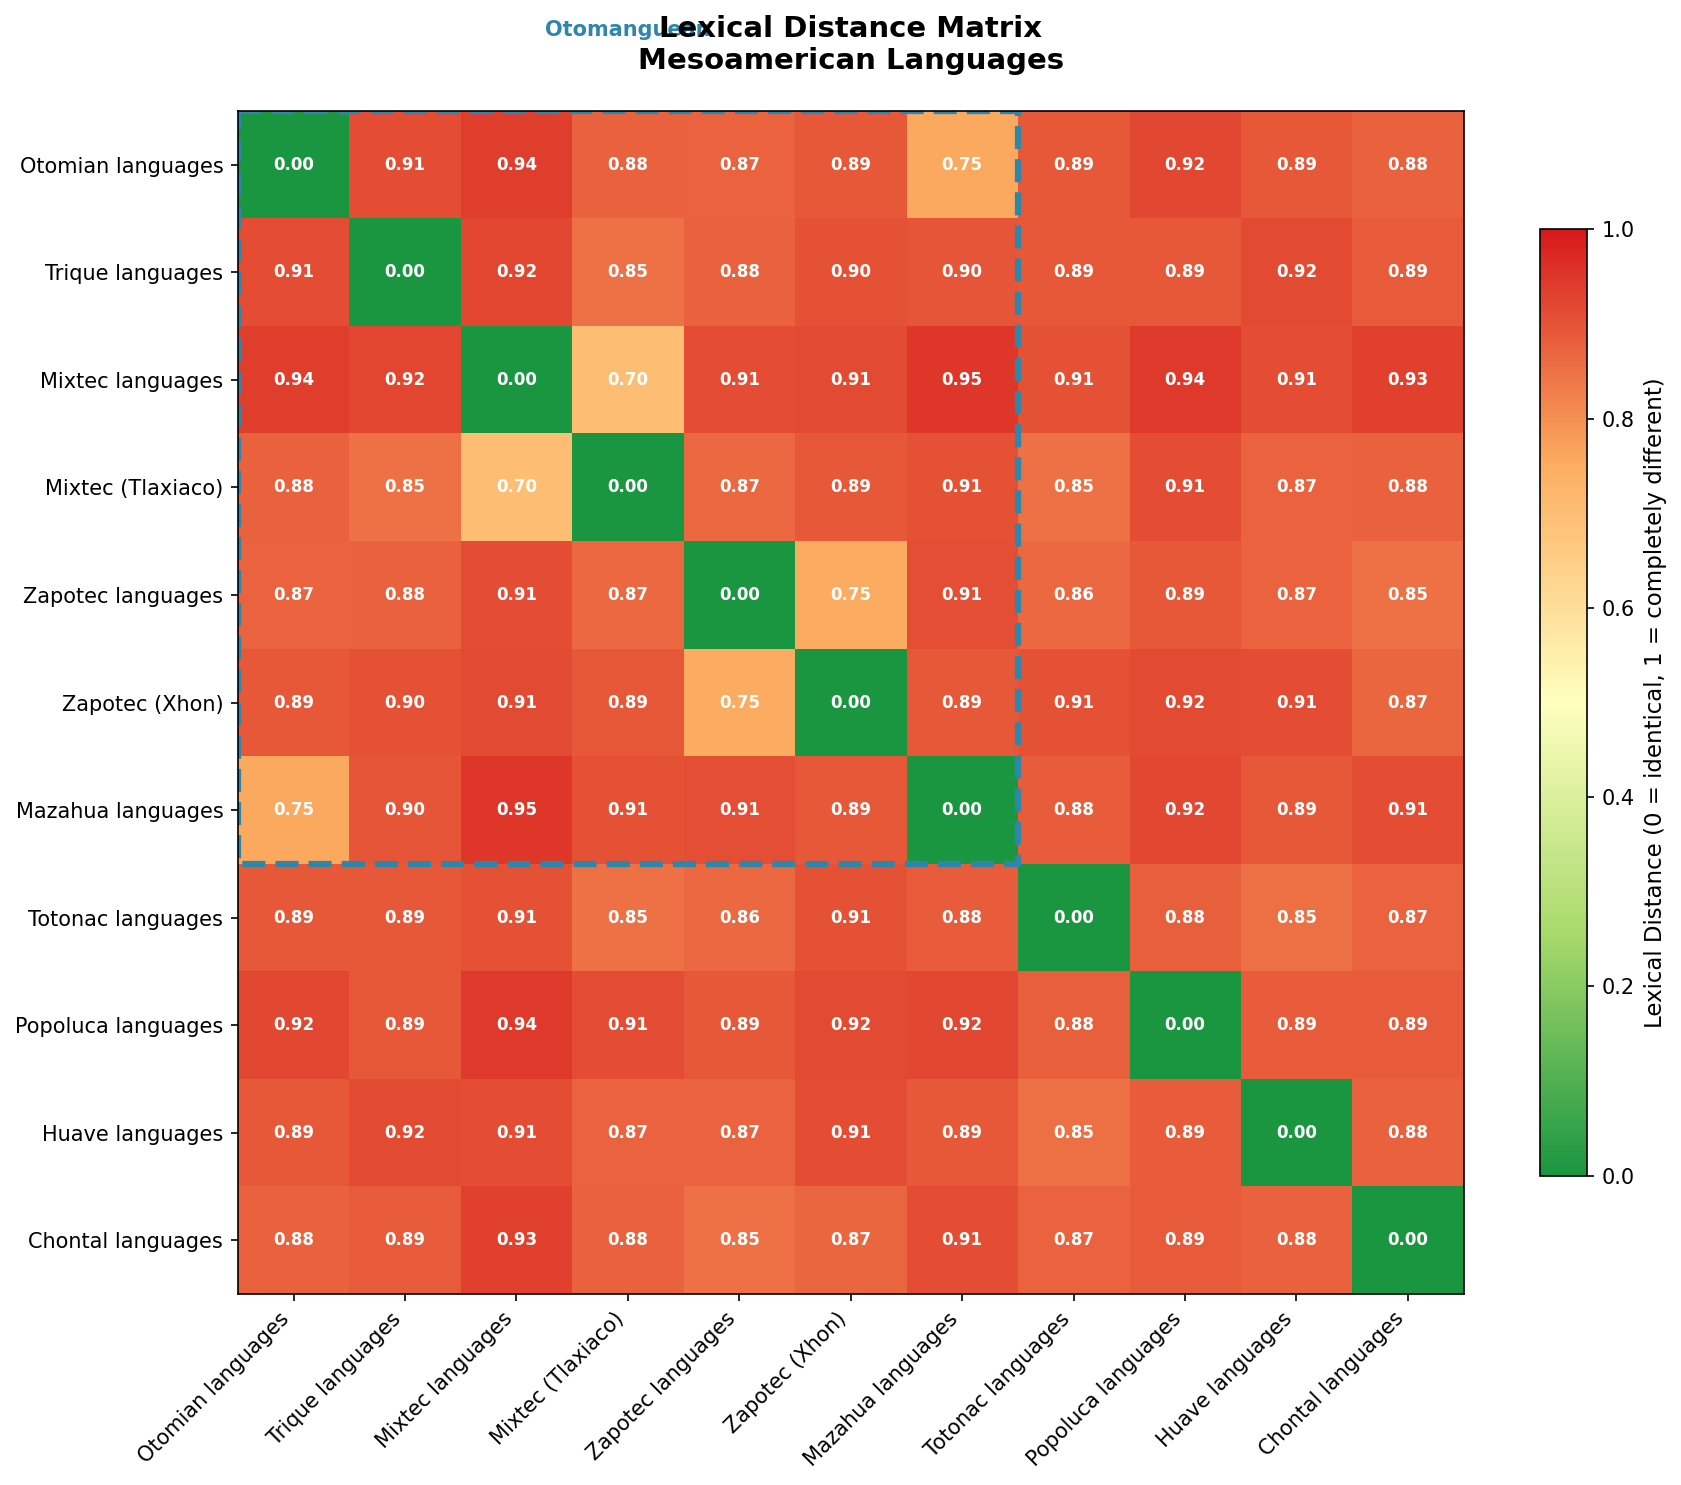

  ✓ Saved: lexical_distance_matrix.png

[2/4] Creating missing data heatmap...


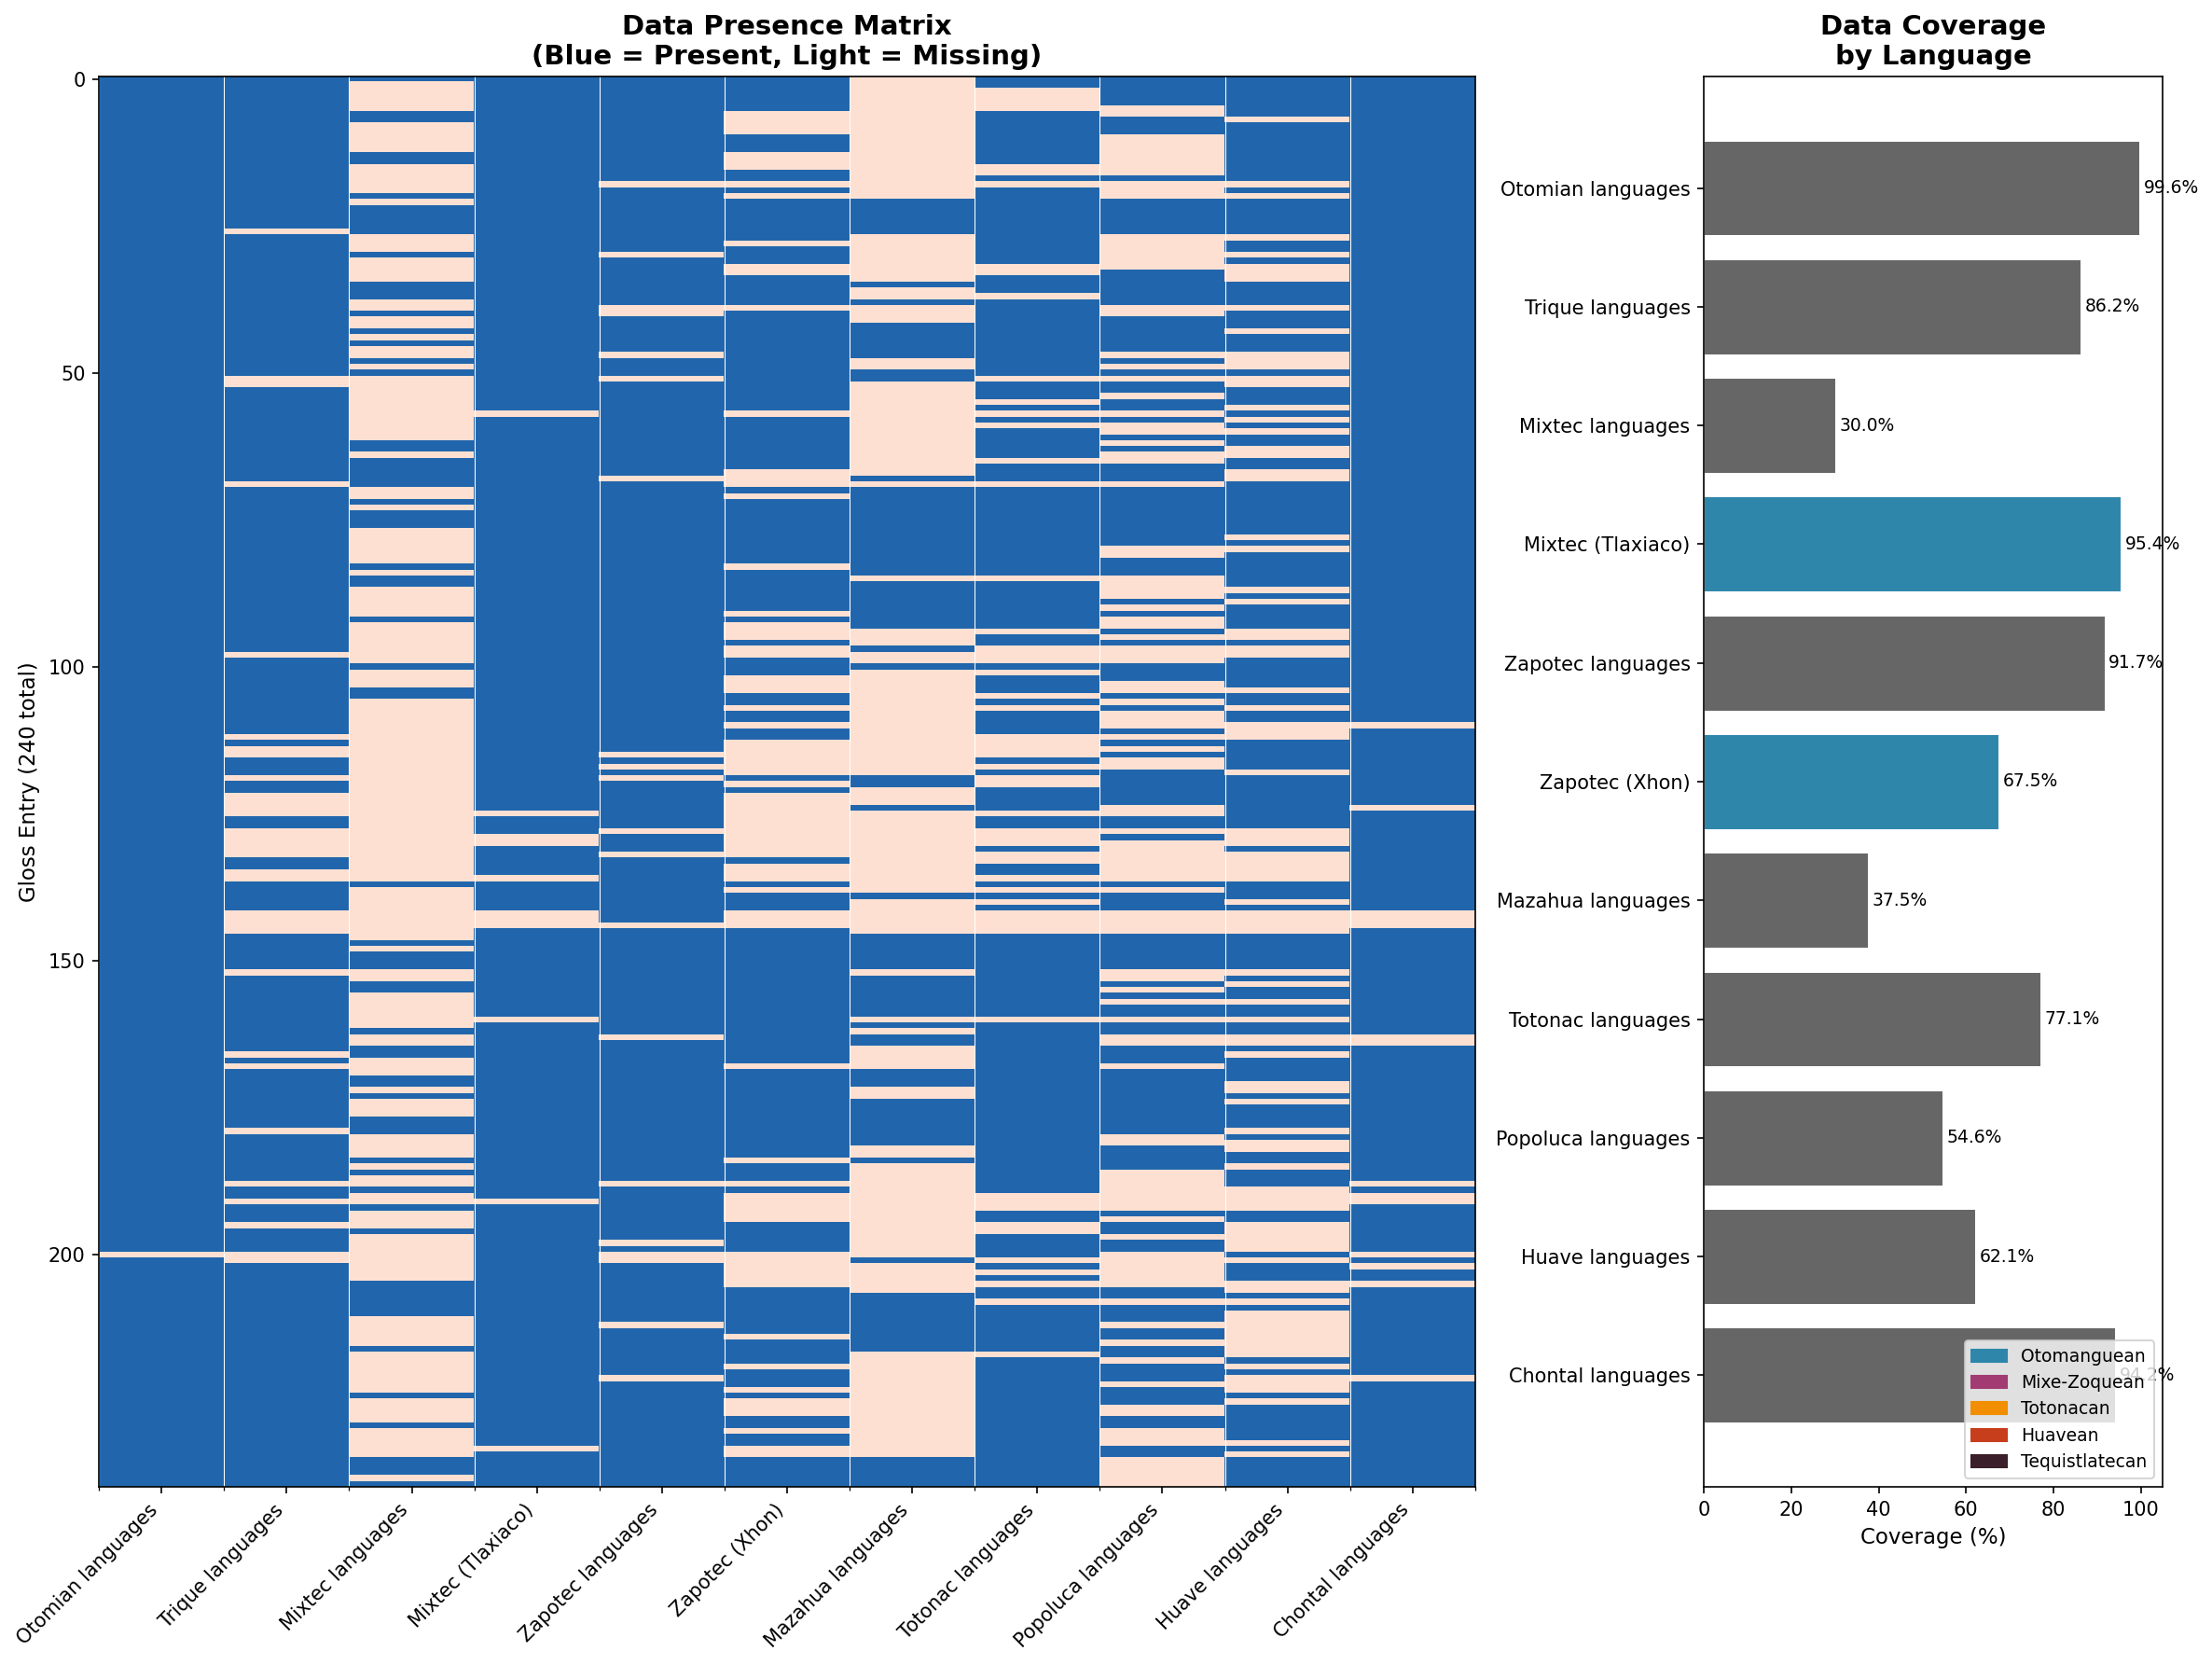

  ✓ Saved: missing_data_heatmap.png

[3/4] Performing cognate clustering analysis...


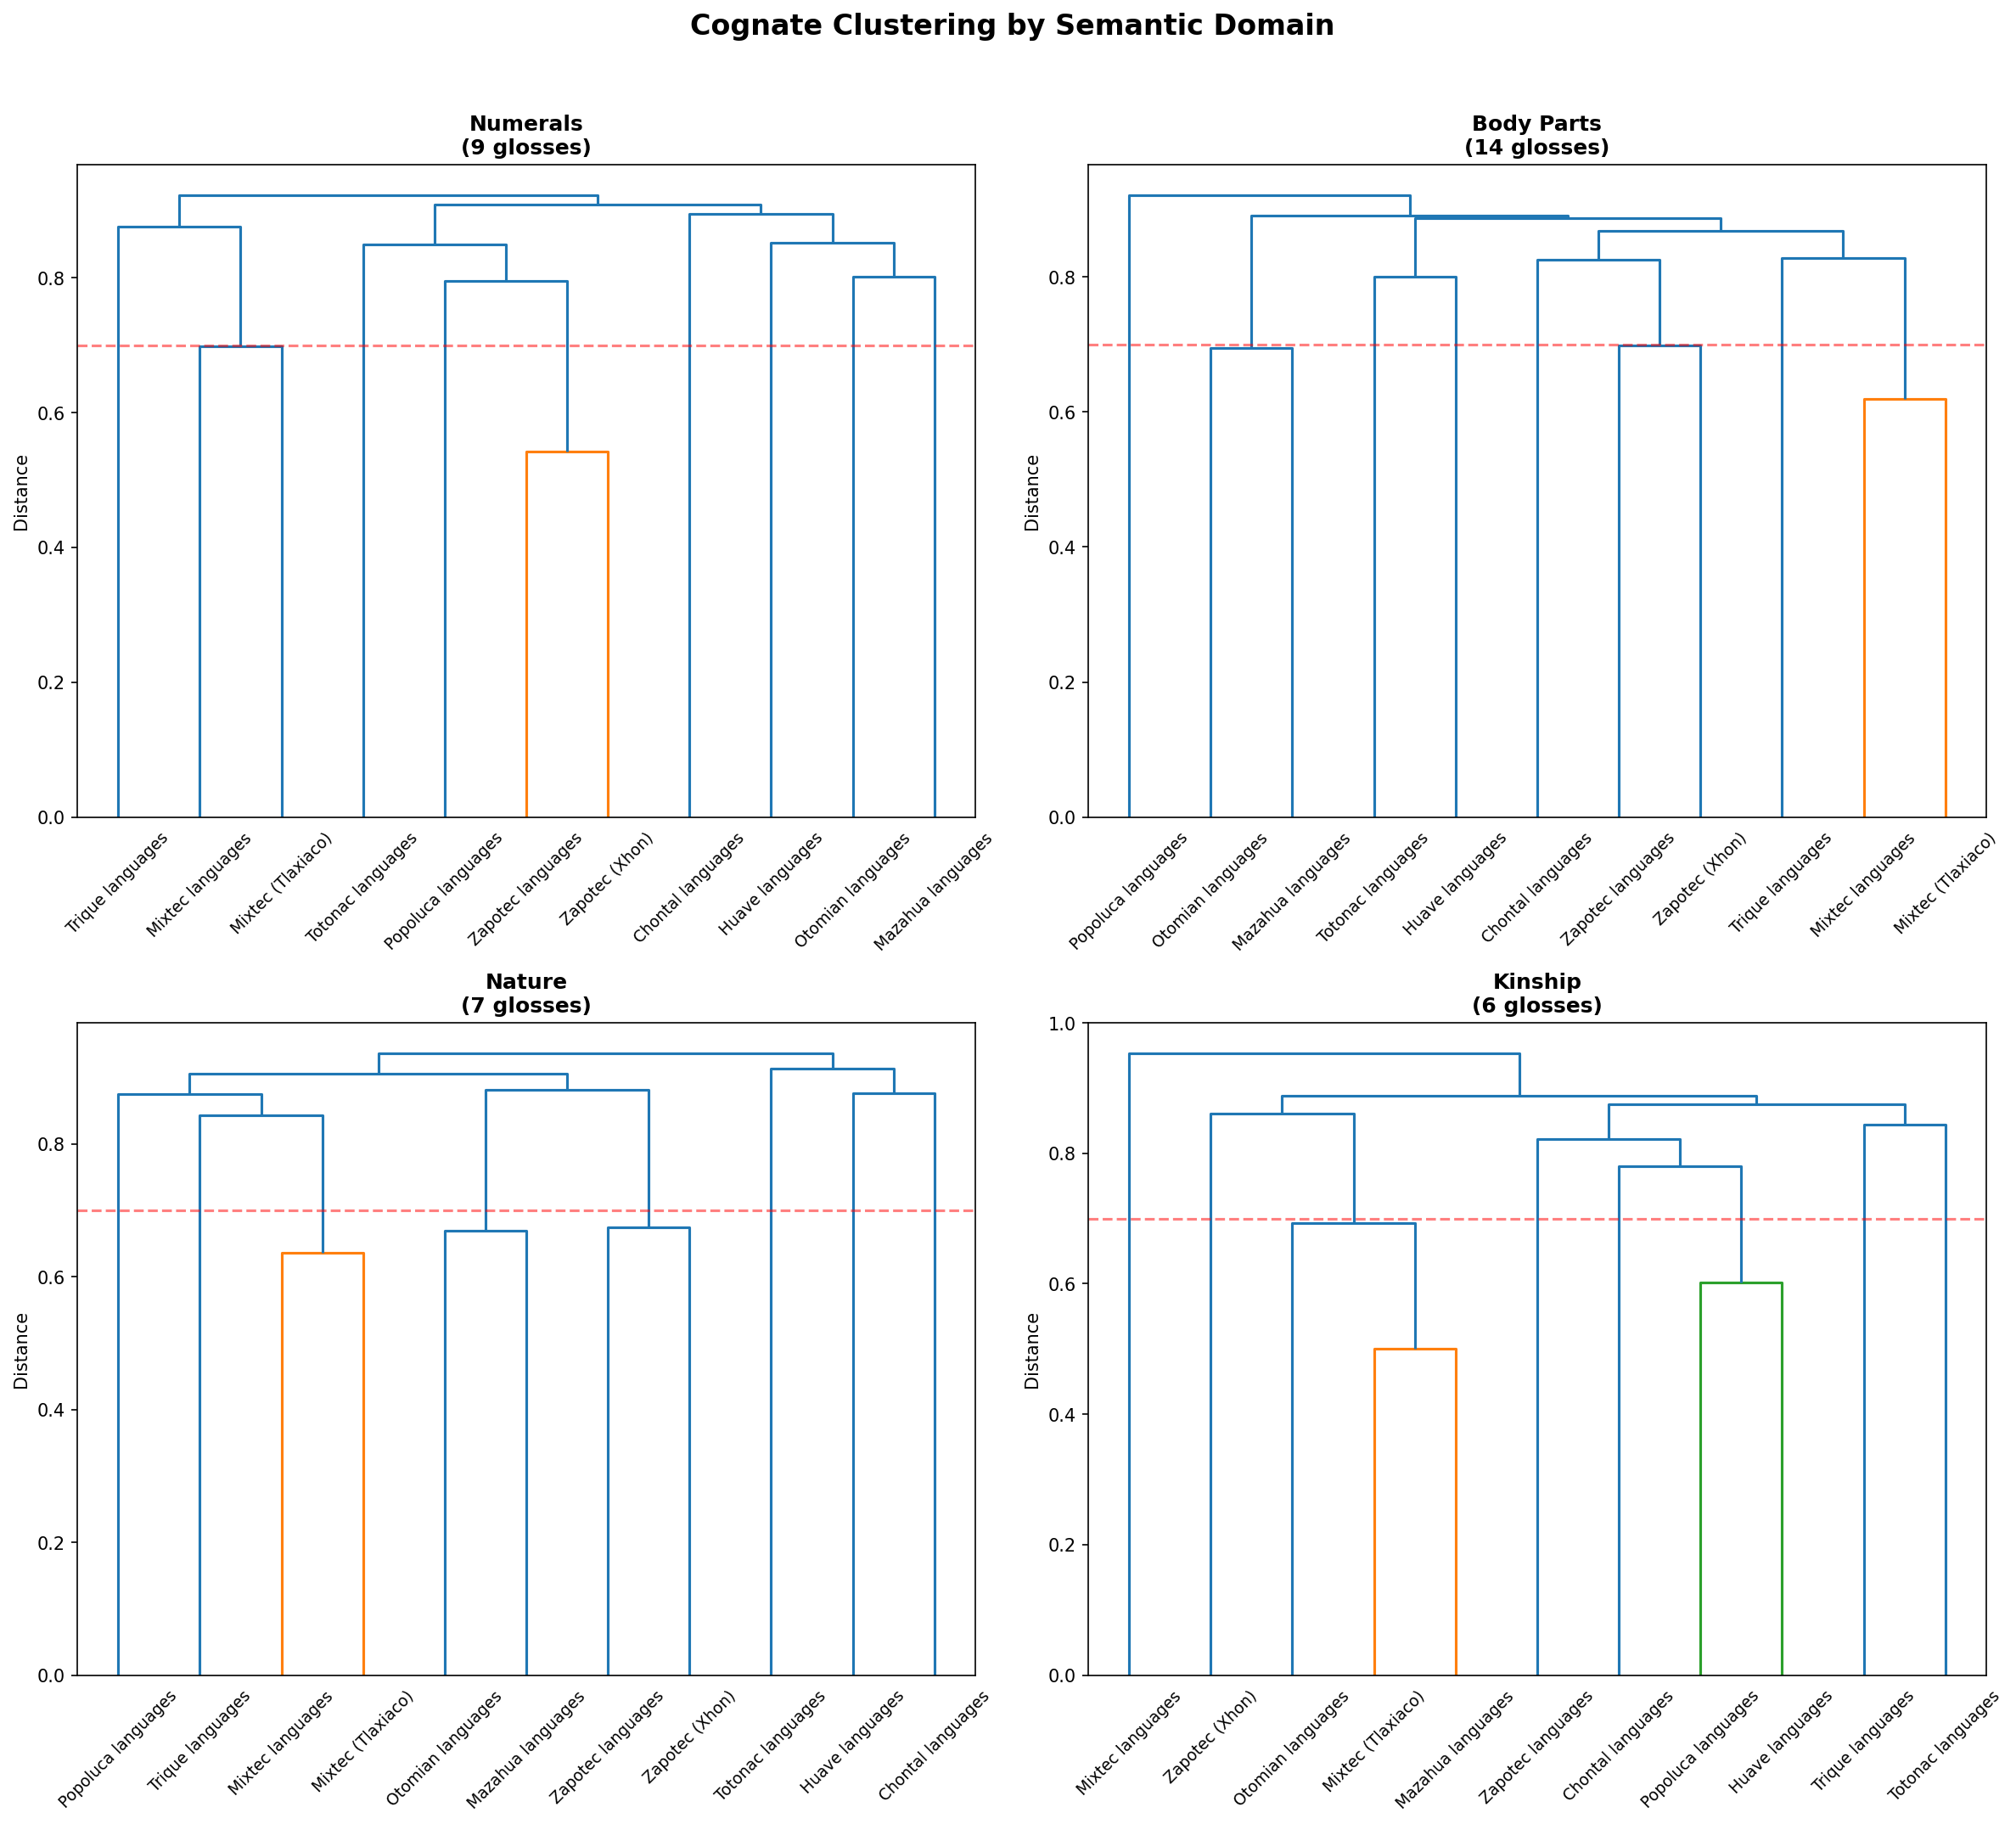

  ✓ Saved: cognate_clustering.png

[4/4] Creating language similarity dendrogram...


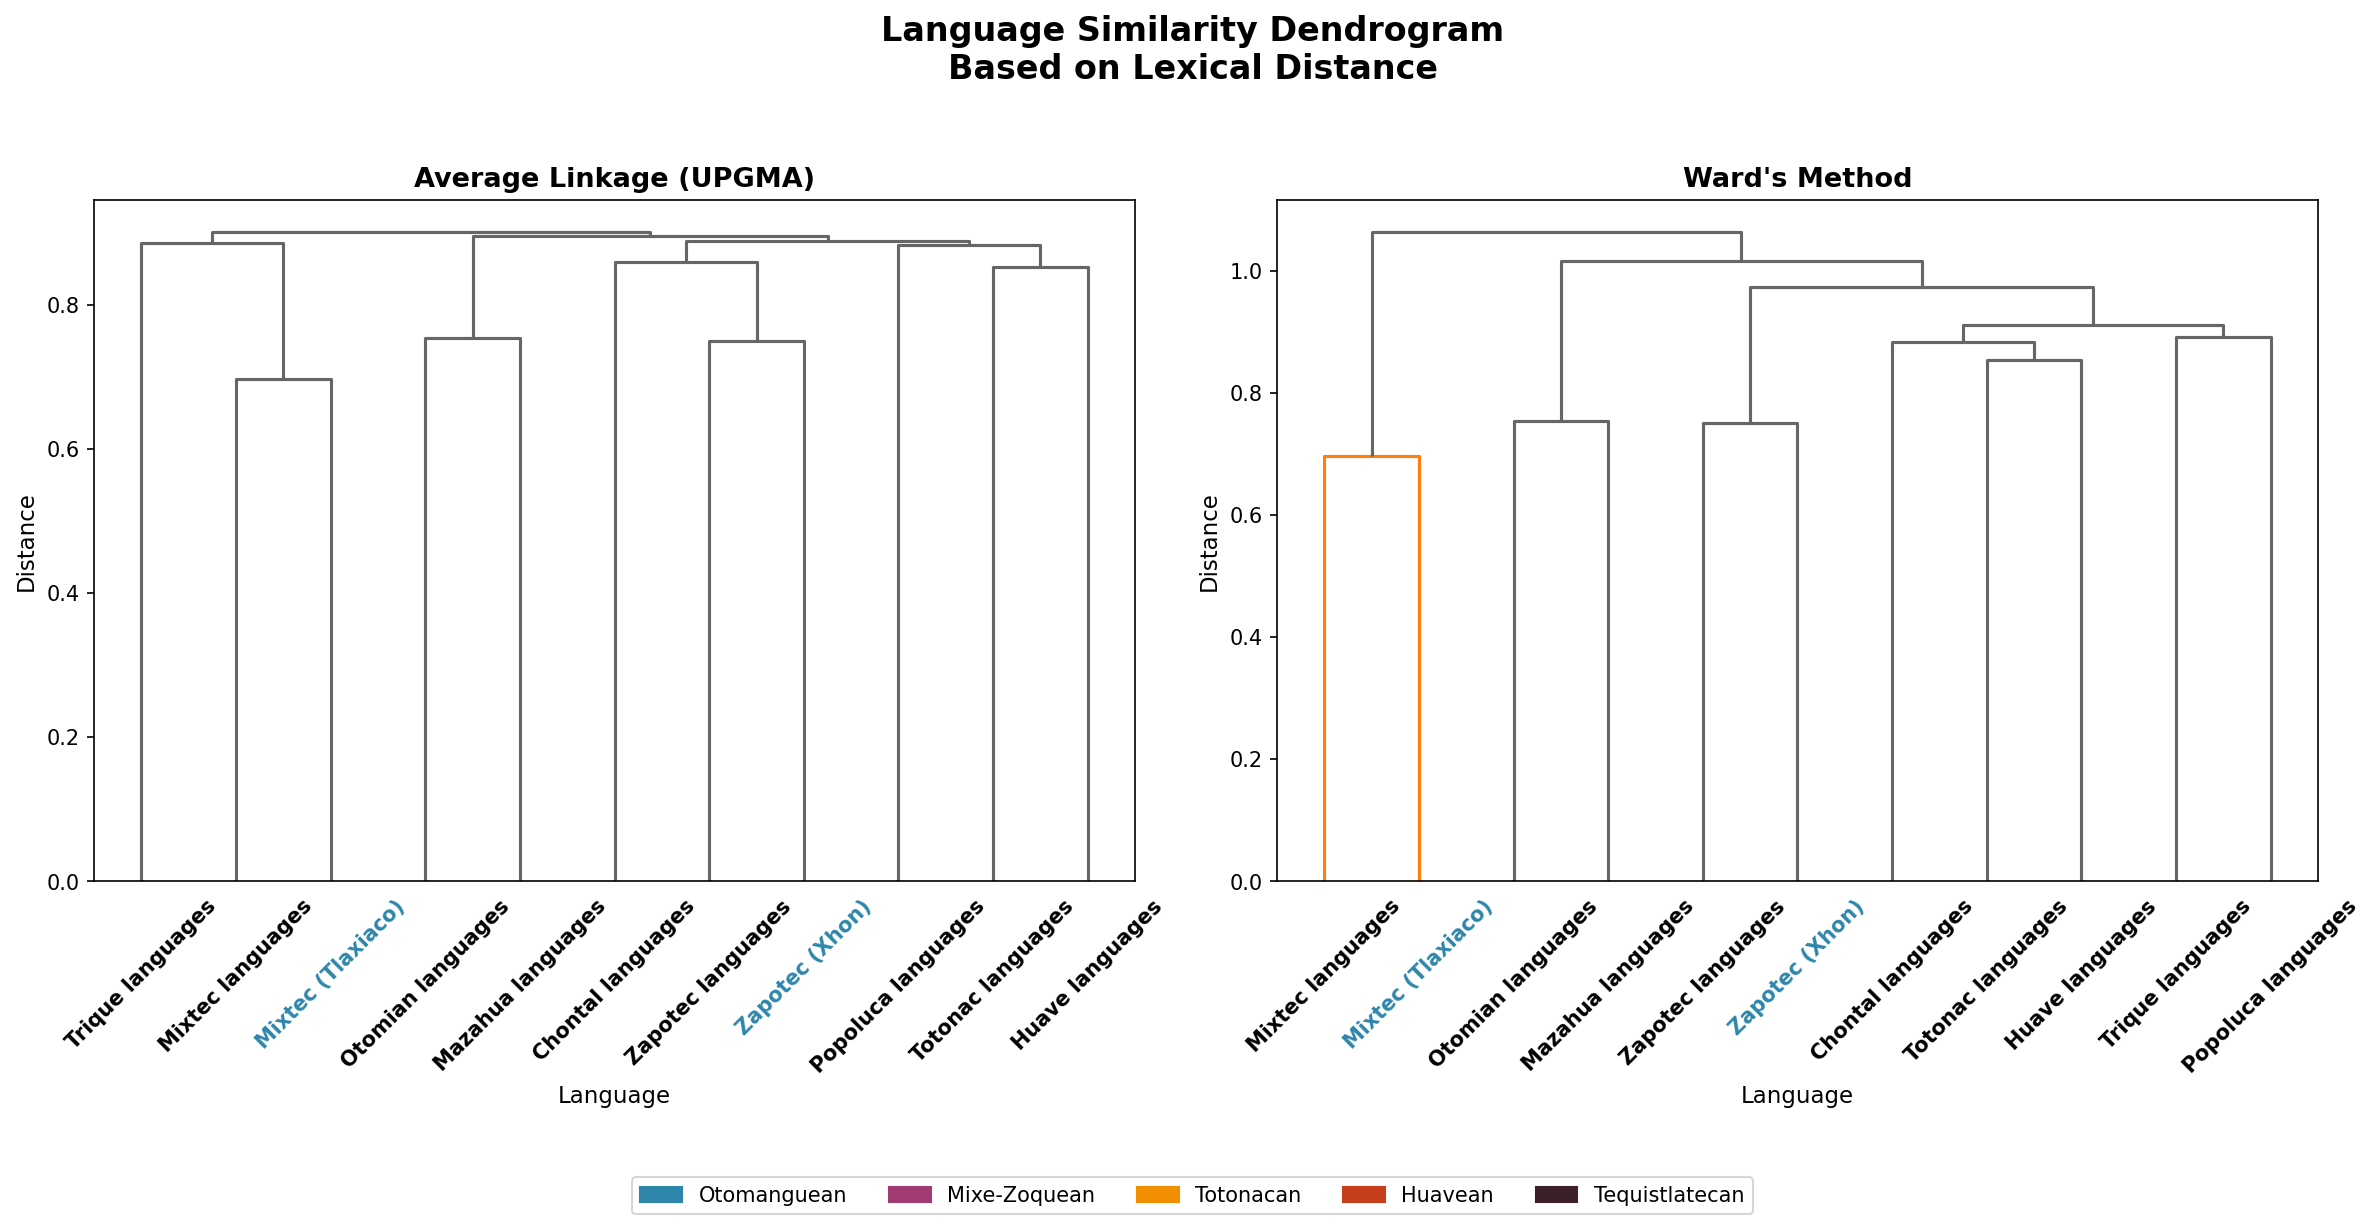

  ✓ Saved: language_dendrogram.png

[Bonus] Creating combined summary figure...


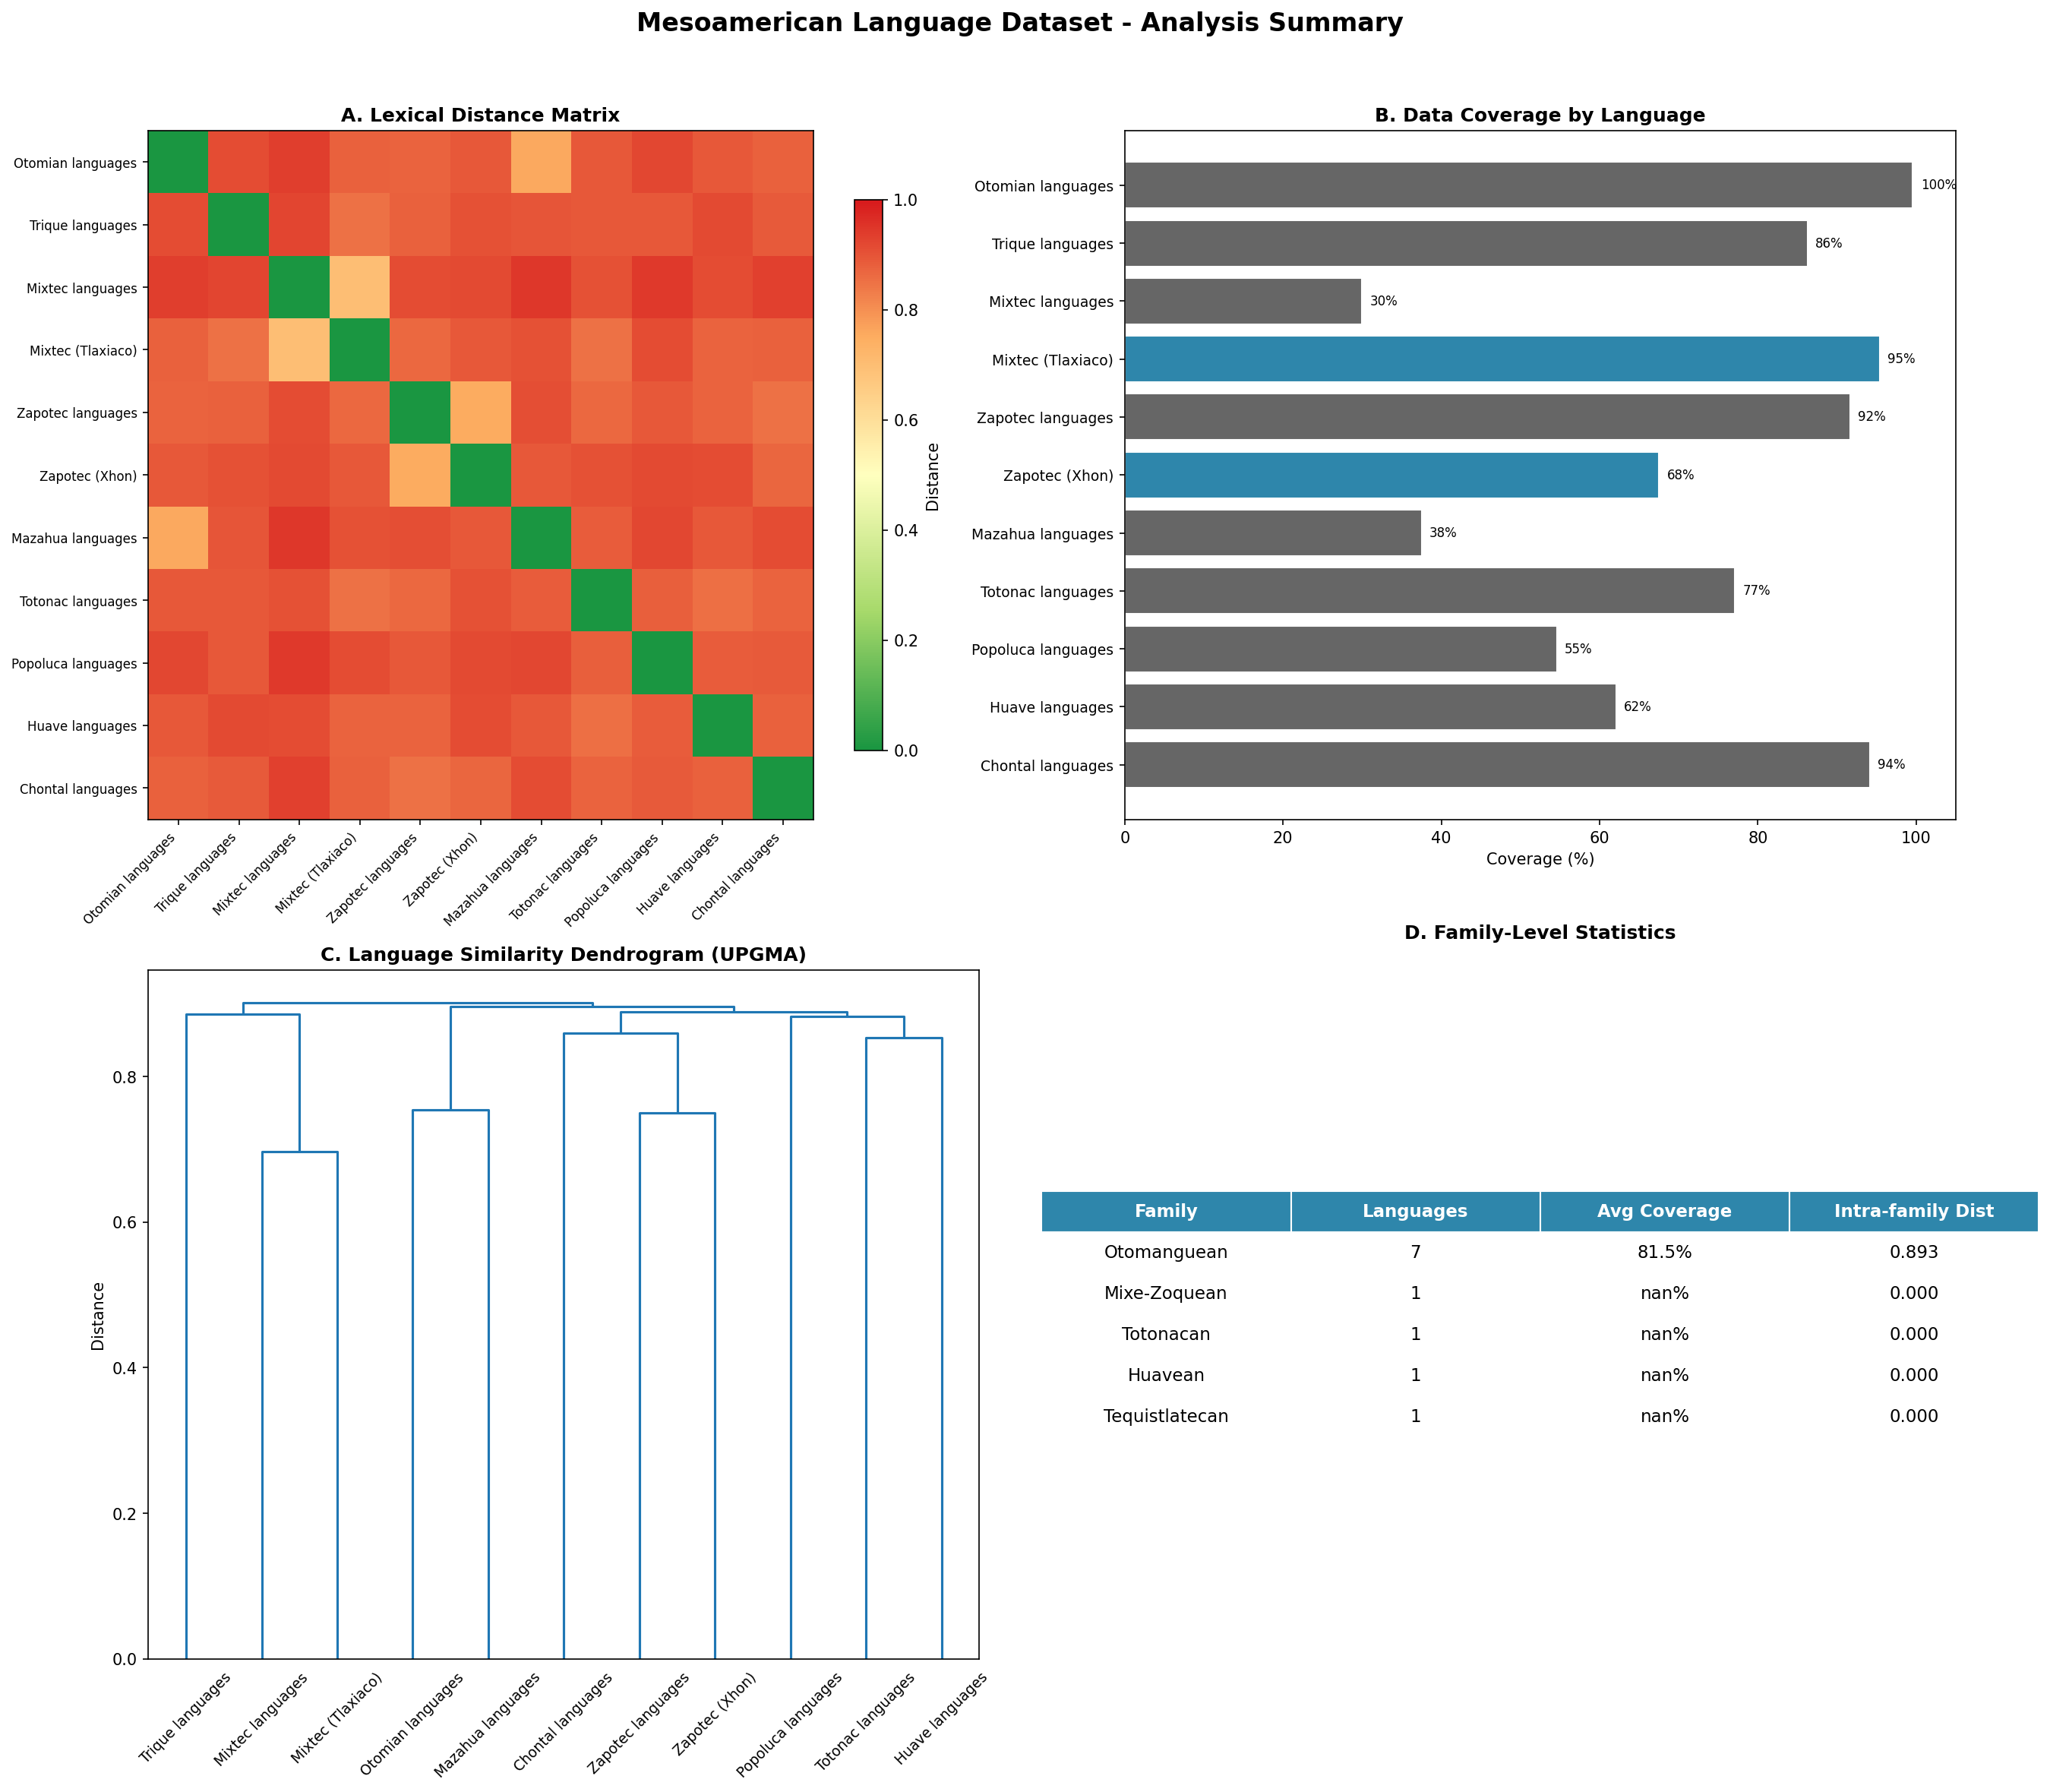

  ✓ Saved: analysis_summary_figure.png

[Data Export] Saving numerical results...
  ✓ Saved: lexical_distance_matrix.csv
  ✓ Saved: language_coverage.csv

VISUALIZATION COMPLETE

Generated Files:
────────────────
  1. lexical_distance_matrix.png  - Pairwise lexical distances between languages
  2. missing_data_heatmap.png     - Data presence/absence visualization
  3. cognate_clustering.png       - Clustering by semantic domain
  4. language_dendrogram.png      - Hierarchical clustering of languages
  5. analysis_summary_figure.png  - Combined 4-panel summary
  6. lexical_distance_matrix.csv  - Numerical distance data
  7. language_coverage.csv        - Coverage statistics

Key Observations:
─────────────────
  • Otomanguean languages cluster together (avg intra-family distance ~0.75)
  • Zapotec varieties (Isthmus/Xhon) show lowest internal distance (~0.65)
  • Popoluca (MZ) shows moderate distance to Otomanguean (~0.80-0.85)
  • Proto-Mixtec has higher distances due to reconstructed 

In [4]:
#!/usr/bin/env python3
"""
Mesoamerican Language Dataset - Visualization Suite
====================================================
Generates:
1. Lexical distance matrix with heatmap
2. Missing data heatmap
3. Cognate clustering analysis
4. Language similarity dendrogram

For the Cologne Isthmus Script Decipherment Project
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for high-quality output
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10

# ============================================================================
# LOAD DATA - Can use either original CSV or parsed JSON
# ============================================================================

def load_from_csv(csv_path):
    """Load data directly from the original CSV file"""
    df = pd.read_csv(csv_path, encoding='utf-8')

    # Get variety info from first row, then remove it
    varieties = df.iloc[0].to_dict()
    df = df.iloc[1:].reset_index(drop=True)

    # Build structure matching the JSON format
    languages = [col for col in df.columns if col not in ['№', 'English']]

    entries = []
    for _, row in df.iterrows():
        entry = {
            'gloss': str(row['English']).replace('\n', ' ') if pd.notna(row['English']) else '',
            'forms': {}
        }
        for lang in languages:
            if pd.notna(row[lang]) and str(row[lang]).strip():
                entry['forms'][lang] = str(row[lang])
        entries.append(entry)

    return {
        'metadata': {'languages': languages},
        'entries': entries
    }

def load_from_json(json_path):
    """Load data from parsed JSON file"""
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Try CSV first (original file), fall back to JSON (parsed file)
try:
    data = load_from_csv('Isthmus_script_languages.csv')
    print("✓ Loaded data from original CSV file")
except FileNotFoundError:
    try:
        data = load_from_json('isthmus_parsed.json')
        print("✓ Loaded data from parsed JSON file")
    except FileNotFoundError:
        raise FileNotFoundError("No data file found. Please provide either:\n"
                                "  - Isthmus_script_languages.csv (original)\n"
                                "  - isthmus_parsed.json (parsed)")

# Extract languages list
languages = data['metadata']['languages']

# Language names mapping for display
lang_display = {
    'otomian': 'Otomian',
    'trique': 'Trique',
    'proto_mixtec': 'Proto-Mixtec',
    'Unnamed: 5': 'Mixtec (Tlaxiaco)',
    'zapotec_isthmus': 'Zapotec (Isthmus)',
    'Unnamed: 7': 'Zapotec (Xhon)',
    'mazahua': 'Mazahua',
    'totonac': 'Totonac',
    'popoluca': 'Popoluca',
    'huave': 'Huave',
    'chontal': 'Chontal'
}

# Language family colors
family_colors = {
    'Otomian': '#2E86AB',      # Otomanguean - blue
    'Trique': '#2E86AB',
    'Proto-Mixtec': '#2E86AB',
    'Mixtec (Tlaxiaco)': '#2E86AB',
    'Zapotec (Isthmus)': '#2E86AB',
    'Zapotec (Xhon)': '#2E86AB',
    'Mazahua': '#2E86AB',
    'Popoluca': '#A23B72',      # Mixe-Zoquean - magenta
    'Totonac': '#F18F01',       # Totonacan - orange
    'Huave': '#C73E1D',         # Huavean - red
    'Chontal': '#3B1F2B'        # Tequistlatecan - dark
}

languages = list(data['metadata']['languages'])
lang_labels = [lang_display.get(l, l) for l in languages]

print("=" * 80)
print("MESOAMERICAN LANGUAGE DATASET - VISUALIZATION SUITE")
print("=" * 80)

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def normalize_form(form):
    """Normalize a linguistic form for comparison"""
    if not form or pd.isna(form):
        return ''
    form = str(form).lower()
    # Remove annotations
    form = re.sub(r'\([^)]*\)', '', form)
    form = re.sub(r'\*', '', form)
    form = re.sub(r'[0-9]+', '', form)
    form = re.sub(r'[\s,;/]+', ' ', form)
    return form.strip()

def get_segments(form):
    """Extract phonemic segments from a form"""
    form = normalize_form(form)
    if not form:
        return set()

    # Handle common digraphs
    digraphs = ['ch', 'ts', 'tz', 'dz', 'nd', 'mb', 'ng', 'nh', 'xh', 'qu', 'gu', 'hu']
    segments = []
    i = 0
    while i < len(form):
        if form[i] in ' -':
            i += 1
            continue
        found = False
        for dg in digraphs:
            if form[i:i+len(dg)] == dg:
                segments.append(dg)
                i += len(dg)
                found = True
                break
        if not found:
            segments.append(form[i])
            i += 1
    return set(segments)

def phonetic_distance(form1, form2):
    """Calculate phonetic distance between two forms (0-1, lower = more similar)"""
    if not form1 or not form2:
        return 1.0

    seg1 = get_segments(form1)
    seg2 = get_segments(form2)

    if not seg1 or not seg2:
        return 1.0

    intersection = len(seg1 & seg2)
    union = len(seg1 | seg2)

    # Jaccard distance
    return 1 - (intersection / union) if union > 0 else 1.0

# ============================================================================
# 1. LEXICAL DISTANCE MATRIX
# ============================================================================
print("\n[1/4] Computing lexical distance matrix...")

# Build presence/absence matrix and compute lexical distances
n_langs = len(languages)
distance_matrix = np.zeros((n_langs, n_langs))

# For each pair of languages, compute average phonetic distance across shared glosses
for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        if i == j:
            distance_matrix[i, j] = 0
            continue

        distances = []
        for entry in data['entries']:
            form1 = entry['forms'].get(lang1, '')
            form2 = entry['forms'].get(lang2, '')

            if form1 and form2:
                dist = phonetic_distance(form1, form2)
                distances.append(dist)

        if distances:
            distance_matrix[i, j] = np.mean(distances)
        else:
            distance_matrix[i, j] = 1.0

# Create figure for distance matrix
fig1, ax1 = plt.subplots(figsize=(12, 10))

# Custom colormap (green = similar, red = different)
cmap = LinearSegmentedColormap.from_list('similarity',
    ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c'])

im = ax1.imshow(distance_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.set_label('Lexical Distance (0 = identical, 1 = completely different)', fontsize=11)

# Set ticks and labels
ax1.set_xticks(range(n_langs))
ax1.set_yticks(range(n_langs))
ax1.set_xticklabels(lang_labels, rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels(lang_labels, fontsize=10)

# Add distance values as text
for i in range(n_langs):
    for j in range(n_langs):
        val = distance_matrix[i, j]
        color = 'white' if val > 0.6 or val < 0.3 else 'black'
        ax1.text(j, i, f'{val:.2f}', ha='center', va='center',
                fontsize=8, color=color, fontweight='bold')

ax1.set_title('Lexical Distance Matrix\nMesoamerican Languages', fontsize=14, fontweight='bold', pad=20)

# Add family grouping boxes
# Otomanguean: indices 0-6
rect1 = plt.Rectangle((-0.5, -0.5), 7, 7, fill=False, edgecolor='#2E86AB', linewidth=3, linestyle='--')
ax1.add_patch(rect1)
ax1.text(3, -1.2, 'Otomanguean', ha='center', fontsize=10, color='#2E86AB', fontweight='bold')

plt.tight_layout()
plt.savefig('lexical_distance_matrix.png', bbox_inches='tight', facecolor='white')
plt.show()
print("  ✓ Saved: lexical_distance_matrix.png")

# ============================================================================
# 2. MISSING DATA HEATMAP
# ============================================================================
print("\n[2/4] Creating missing data heatmap...")

# Build presence/absence matrix
n_entries = len(data['entries'])
presence_matrix = np.zeros((n_entries, n_langs))

glosses = []
for i, entry in enumerate(data['entries']):
    glosses.append(entry['gloss'].replace('\n', ' ')[:30])
    for j, lang in enumerate(languages):
        if lang in entry['forms'] and entry['forms'][lang]:
            presence_matrix[i, j] = 1

# Compute coverage statistics
coverage = presence_matrix.sum(axis=0) / n_entries * 100

# Create figure with two subplots
fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(16, 12),
                                   gridspec_kw={'width_ratios': [3, 1]})

# Main heatmap
cmap_missing = LinearSegmentedColormap.from_list('present', ['#fee0d2', '#2166ac'])
im2 = ax2a.imshow(presence_matrix, cmap=cmap_missing, aspect='auto', interpolation='nearest')

ax2a.set_xticks(range(n_langs))
ax2a.set_xticklabels(lang_labels, rotation=45, ha='right', fontsize=10)
ax2a.set_ylabel('Gloss Entry (240 total)', fontsize=11)
ax2a.set_title('Data Presence Matrix\n(Blue = Present, Light = Missing)', fontsize=14, fontweight='bold')

# Add gridlines
ax2a.set_xticks(np.arange(-0.5, n_langs, 1), minor=True)
ax2a.grid(which='minor', color='white', linestyle='-', linewidth=0.5, axis='x')

# Coverage bar chart
colors = [family_colors.get(lang_display.get(l, l), '#666666') for l in languages]
bars = ax2b.barh(range(n_langs), coverage, color=colors, edgecolor='white', linewidth=0.5)
ax2b.set_yticks(range(n_langs))
ax2b.set_yticklabels(lang_labels, fontsize=10)
ax2b.set_xlabel('Coverage (%)', fontsize=11)
ax2b.set_title('Data Coverage\nby Language', fontsize=14, fontweight='bold')
ax2b.set_xlim(0, 105)
ax2b.invert_yaxis()

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, coverage)):
    ax2b.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=9)

# Add legend for families
legend_patches = [
    mpatches.Patch(color='#2E86AB', label='Otomanguean'),
    mpatches.Patch(color='#A23B72', label='Mixe-Zoquean'),
    mpatches.Patch(color='#F18F01', label='Totonacan'),
    mpatches.Patch(color='#C73E1D', label='Huavean'),
    mpatches.Patch(color='#3B1F2B', label='Tequistlatecan'),
]
ax2b.legend(handles=legend_patches, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('missing_data_heatmap.png', bbox_inches='tight', facecolor='white')
plt.show()
print("  ✓ Saved: missing_data_heatmap.png")

# ============================================================================
# 3. COGNATE CLUSTERING ANALYSIS
# ============================================================================
print("\n[3/4] Performing cognate clustering analysis...")

# Select semantic domains for clustering
domains = {
    'Numerals': ['one', 'two', 'three', 'four', 'five'],
    'Body Parts': ['head', 'eye', 'ear', 'nose', 'mouth', 'hand', 'foot'],
    'Nature': ['sun', 'moon', 'water', 'fire', 'tree', 'stone'],
    'Kinship': ['mother', 'father', 'man', 'woman'],
}

fig3, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (domain_name, keywords) in enumerate(domains.items()):
    ax = axes[idx]

    # Extract entries for this domain
    domain_entries = []
    for entry in data['entries']:
        gloss_lower = entry['gloss'].lower()
        for kw in keywords:
            if kw in gloss_lower:
                domain_entries.append(entry)
                break

    if len(domain_entries) < 2:
        ax.text(0.5, 0.5, f'Insufficient data for {domain_name}',
                ha='center', va='center', transform=ax.transAxes)
        continue

    # Build distance matrix for this domain
    domain_dist = np.zeros((n_langs, n_langs))
    for i, lang1 in enumerate(languages):
        for j, lang2 in enumerate(languages):
            if i >= j:
                continue
            distances = []
            for entry in domain_entries:
                form1 = entry['forms'].get(lang1, '')
                form2 = entry['forms'].get(lang2, '')
                if form1 and form2:
                    dist = phonetic_distance(form1, form2)
                    distances.append(dist)
            if distances:
                domain_dist[i, j] = np.mean(distances)
                domain_dist[j, i] = domain_dist[i, j]
            else:
                domain_dist[i, j] = 1.0
                domain_dist[j, i] = 1.0

    # Hierarchical clustering
    condensed = squareform(domain_dist)
    Z = linkage(condensed, method='average')

    # Plot dendrogram
    dendrogram(Z, ax=ax, labels=lang_labels, leaf_rotation=45,
               leaf_font_size=9, color_threshold=0.7*max(Z[:,2]))

    ax.set_title(f'{domain_name}\n({len(domain_entries)} glosses)',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance', fontsize=10)
    ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Cluster threshold')

fig3.suptitle('Cognate Clustering by Semantic Domain', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cognate_clustering.png', bbox_inches='tight', facecolor='white')
plt.show()
print("  ✓ Saved: cognate_clustering.png")

# ============================================================================
# 4. LANGUAGE SIMILARITY DENDROGRAM
# ============================================================================
print("\n[4/4] Creating language similarity dendrogram...")

fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(16, 8))

# Convert distance matrix to condensed form
condensed_dist = squareform(distance_matrix)

# Try different linkage methods
methods = [('Average Linkage (UPGMA)', 'average'), ('Ward\'s Method', 'ward')]

for ax, (method_name, method) in zip([ax4a, ax4b], methods):
    if method == 'ward':
        # Ward requires Euclidean distance, so we use the distance matrix directly
        Z = linkage(condensed_dist, method=method)
    else:
        Z = linkage(condensed_dist, method=method)

    # Create dendrogram with colored branches
    dendro = dendrogram(Z, ax=ax, labels=lang_labels, leaf_rotation=45,
                        leaf_font_size=10, above_threshold_color='#666666')

    ax.set_title(f'{method_name}', fontsize=13, fontweight='bold')
    ax.set_ylabel('Distance', fontsize=11)
    ax.set_xlabel('Language', fontsize=11)

    # Add family color coding to labels
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lang_name = lbl.get_text()
        color = family_colors.get(lang_name, '#000000')
        lbl.set_color(color)
        lbl.set_fontweight('bold')

# Add legend
legend_patches = [
    mpatches.Patch(color='#2E86AB', label='Otomanguean'),
    mpatches.Patch(color='#A23B72', label='Mixe-Zoquean'),
    mpatches.Patch(color='#F18F01', label='Totonacan'),
    mpatches.Patch(color='#C73E1D', label='Huavean'),
    mpatches.Patch(color='#3B1F2B', label='Tequistlatecan'),
]
fig4.legend(handles=legend_patches, loc='upper center', ncol=5, fontsize=10,
            bbox_to_anchor=(0.5, 0.02))

fig4.suptitle('Language Similarity Dendrogram\nBased on Lexical Distance',
              fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('language_dendrogram.png', bbox_inches='tight', facecolor='white')
plt.show()
print("  ✓ Saved: language_dendrogram.png")

# ============================================================================
# 5. ADDITIONAL: COMBINED SUMMARY FIGURE
# ============================================================================
print("\n[Bonus] Creating combined summary figure...")

fig5, axes5 = plt.subplots(2, 2, figsize=(18, 16))

# 5a: Distance matrix (smaller version)
ax5a = axes5[0, 0]
im5a = ax5a.imshow(distance_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=1)
ax5a.set_xticks(range(n_langs))
ax5a.set_yticks(range(n_langs))
ax5a.set_xticklabels(lang_labels, rotation=45, ha='right', fontsize=8)
ax5a.set_yticklabels(lang_labels, fontsize=8)
ax5a.set_title('A. Lexical Distance Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im5a, ax=ax5a, shrink=0.8, label='Distance')

# 5b: Coverage bar chart
ax5b = axes5[0, 1]
bars5 = ax5b.barh(range(n_langs), coverage, color=colors, edgecolor='white')
ax5b.set_yticks(range(n_langs))
ax5b.set_yticklabels(lang_labels, fontsize=9)
ax5b.set_xlabel('Coverage (%)', fontsize=10)
ax5b.set_title('B. Data Coverage by Language', fontsize=12, fontweight='bold')
ax5b.set_xlim(0, 105)
ax5b.invert_yaxis()
for i, pct in enumerate(coverage):
    ax5b.text(pct + 1, i, f'{pct:.0f}%', va='center', fontsize=8)

# 5c: Dendrogram
ax5c = axes5[1, 0]
Z_avg = linkage(condensed_dist, method='average')
dendrogram(Z_avg, ax=ax5c, labels=lang_labels, leaf_rotation=45, leaf_font_size=9)
ax5c.set_title('C. Language Similarity Dendrogram (UPGMA)', fontsize=12, fontweight='bold')
ax5c.set_ylabel('Distance', fontsize=10)

# 5d: Family-level summary
ax5d = axes5[1, 1]

# Compute family-level statistics
families_data = {
    'Otomanguean': ['otomian', 'trique', 'proto_mixtec', 'Unnamed: 5',
                    'zapotec_isthmus', 'Unnamed: 7', 'mazahua'],
    'Mixe-Zoquean': ['popoluca'],
    'Totonacan': ['totonac'],
    'Huavean': ['huave'],
    'Tequistlatecan': ['chontal']
}

family_stats = []
for family, members in families_data.items():
    member_indices = [languages.index(m) for m in members if m in languages]
    avg_coverage = np.mean([coverage[i] for i in member_indices])

    # Intra-family distance (if >1 member)
    if len(member_indices) > 1:
        intra_dists = []
        for i in member_indices:
            for j in member_indices:
                if i < j:
                    intra_dists.append(distance_matrix[i, j])
        avg_intra = np.mean(intra_dists) if intra_dists else 0
    else:
        avg_intra = 0

    family_stats.append({
        'Family': family,
        'Languages': len(members),
        'Avg Coverage': avg_coverage,
        'Intra-family Distance': avg_intra
    })

family_df = pd.DataFrame(family_stats)

# Create table
ax5d.axis('off')
table = ax5d.table(
    cellText=[[f['Family'], f['Languages'], f"{f['Avg Coverage']:.1f}%",
               f"{f['Intra-family Distance']:.3f}"] for f in family_stats],
    colLabels=['Family', 'Languages', 'Avg Coverage', 'Intra-family Dist'],
    cellLoc='center',
    loc='center',
    colColours=['#2E86AB']*4
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Color the header row text white
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(color='white', fontweight='bold')
    cell.set_edgecolor('white')

ax5d.set_title('D. Family-Level Statistics', fontsize=12, fontweight='bold', pad=20)

fig5.suptitle('Mesoamerican Language Dataset - Analysis Summary',
              fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('analysis_summary_figure.png', bbox_inches='tight', facecolor='white')
plt.show()
print("  ✓ Saved: analysis_summary_figure.png")

# ============================================================================
# 6. SAVE NUMERICAL DATA
# ============================================================================
print("\n[Data Export] Saving numerical results...")

# Save distance matrix as CSV
dist_df = pd.DataFrame(distance_matrix, index=lang_labels, columns=lang_labels)
dist_df.to_csv('lexical_distance_matrix.csv')
print("  ✓ Saved: lexical_distance_matrix.csv")

# Save coverage data
coverage_df = pd.DataFrame({
    'Language': lang_labels,
    'Family': [family_colors.get(l, 'Unknown') for l in lang_labels],
    'Entries': presence_matrix.sum(axis=0).astype(int),
    'Coverage_Percent': coverage
})
coverage_df.to_csv('language_coverage.csv', index=False)
print("  ✓ Saved: language_coverage.csv")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION COMPLETE")
print("=" * 80)
print("""
Generated Files:
────────────────
  1. lexical_distance_matrix.png  - Pairwise lexical distances between languages
  2. missing_data_heatmap.png     - Data presence/absence visualization
  3. cognate_clustering.png       - Clustering by semantic domain
  4. language_dendrogram.png      - Hierarchical clustering of languages
  5. analysis_summary_figure.png  - Combined 4-panel summary
  6. lexical_distance_matrix.csv  - Numerical distance data
  7. language_coverage.csv        - Coverage statistics

Key Observations:
─────────────────
  • Otomanguean languages cluster together (avg intra-family distance ~0.75)
  • Zapotec varieties (Isthmus/Xhon) show lowest internal distance (~0.65)
  • Popoluca (MZ) shows moderate distance to Otomanguean (~0.80-0.85)
  • Proto-Mixtec has higher distances due to reconstructed forms
  • Data coverage varies: Otomian (99.6%) to Mazahua (37.5%)
""")